<a href="https://colab.research.google.com/github/dani-jimlar/XAI_AIPI_590/blob/main/XAI_6_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

!pip install numpy==1.25.2 pandas==2.0.3 scikit-learn==1.2.2 shap==0.45.1
!pip install git+https://github.com/MaximeJumelle/ALEPython.git@dev#egg=alepython
#!pip install --upgrade scikit-learn


  Cloning https://github.com/MaximeJumelle/ALEPython.git (to revision dev) to /tmp/pip-install-2yvy1gia/alepython_878d344f69a94e8da1d90156ce2e527e
  Running command git clone --filter=blob:none --quiet https://github.com/MaximeJumelle/ALEPython.git /tmp/pip-install-2yvy1gia/alepython_878d344f69a94e8da1d90156ce2e527e
  Resolved https://github.com/MaximeJumelle/ALEPython.git to commit 286350ab674980a32270db2a0b5ccca1380312a7
  Preparing metadata (setup.py) ... done


#AIPI 590 - XAI | Assignment 6
## Explainable Techniques II
## Daniela Jiménez Lara


# Data
Data: PAES- Chilean Higher Education Admission Test (Prueba de acceso a la Educación Superior).
The PAES is the most recent selection test to access the Chilean higher education system. It favors the application and understanding of knowledge instead of memorization; and aims to close the existing gap between private and public school students' scores. The data gives the scores on Mathematics and Reading Competency as well as socioeconomic variables. For this exercise we will focus only on the Mathematics score and measure how other socioeconomic variables might explain the scores.

In [2]:
""" Prepare data """
import pandas as pd

# load data

import pandas as pd
path_score='/content/drive/MyDrive/XAI_2/asiign_4/A_INSCRITOS_PUNTAJES_2023_PAES_PUB_MRUN.csv'
test_score = pd.read_csv(path_score, delimiter=";", low_memory=False)

score_math=test_score[['MRUN', 'MATE1_REG_ACTUAL', 'ANYO_PROCESO', 'COD_SEXO', 'FECHA_NACIMIENTO', 'RBD', 'CODIGO_ENS',
                       'LOCAL_EDUCACIONAL', 'UNIDAD_EDUCATIVA', 'NOMBRE_UNIDAD_EDUC', 'RAMA_EDUCACIONAL', 'DEPENDENCIA',
                       'CODIGO_REGION_EGRESO', 'NOMBRE_REGION_EGRESO', 'CODIGO_PROVINCIA_EGRESO', 'NOMBRE_PROVINCIA_EGRESO',
                       'CODIGO_COMUNA_EGRESO', 'NOMBRE_COMUNA_EGRESO', 'ANYO_DE_EGRESO', 'PROMEDIO_NOTAS', 'PTJE_NEM']]
score_read=test_score[['MRUN', 'CLEC_REG_ACTUAL']]


path_socio='/content/drive/MyDrive/XAI_2/asiign_4/B_SOCIOECONOMICO_DOMICILIO_2023_PAES_PUB_MRUN.csv'
socioeconomic = pd.read_csv(path_socio, delimiter=";")

data = pd.merge(score_math, socioeconomic, how="inner", on=["MRUN",'ANYO_PROCESO','FECHA_NACIMIENTO'])
data = pd.merge(score_read, data, how="inner", on="MRUN")

# Drop nas from target vaiables and drop uneeded columns
data = data[data["MATE1_REG_ACTUAL"] != " "]
data = data[data["CLEC_REG_ACTUAL"] != " "]
data = data[data["DEPENDENCIA"] != " "]
data = data[data["DEPENDENCIA"] != " "]

data["MATE1_REG_ACTUAL"] = data["MATE1_REG_ACTUAL"].astype(int)
data["CLEC_REG_ACTUAL"] = data["CLEC_REG_ACTUAL"].astype(int)

data = data[data["MATE1_REG_ACTUAL"] > 0]
data = data[data["CLEC_REG_ACTUAL"] > 0]
data = data.drop(columns=data.filter(like='CODIGO').columns)


# map and tranform catagorical variables, rename columns

dependency_mapping = {
    "1": "Public School",
    "2": "Public School",
    "3": "Private subsidized School",
    "4": "Private non-subsidized School",
    "5": "Delegated Administration School",
    "6": "Public School",
}

gender_mapping = {
    1: "Male",
    2: "Female"
}

razon_paes={
    1:' Porque busco mejorar alguno(s) de mis resultados pasados.'
    ,2: 'Para estudiar una carrera técnica'
    ,3: 'Para estudiar una carrera universitaria'
    ,4: 'Para ingresar a la PDI, Fuerzas armadas'
    ,5: 'Por otra razón'
    ,6: 'Porque no pude rendir alguna aplicación pasada '
    ,7: 'Porque soy profesional de la educación y deseo conocer el instrumento'
    ,8: 'Porque me obligaron a inscribirme en el colegio'
    ,9: 'Prefiero no responder'
}

uso_espacio_mapping={
     0: 'No aplica'
    ,1: 'Menos de 1 hora a la semana '
    ,2: 'Entre 1 y 3 horas a la semana'
    ,3: 'Entre 3 y 5 horas a la semana'
    ,4: 'Más de 5 horas a la semana'
}

tranquilidad_colegio_mapping={
    1: 'Nunca'
    ,2: 'Rara vez'
    ,3: 'A menudo'
    ,4: 'Casi siempre'
    ,5: 'Siempre'
    ,9: 'Prefiero no responder'
}

data["DEPENDENCIA"] = data["DEPENDENCIA"].replace(dependency_mapping)

data["SEXO"] = data["SEXO"].replace(gender_mapping)
data["RAZON_PRINCIPAL_PAES"] = data["RAZON_PRINCIPAL_PAES"].replace(razon_paes)

data["TRANQUILIDAD_COLEGIO"]= data["TRANQUILIDAD_COLEGIO"].replace(tranquilidad_colegio_mapping)
data["TRABAJO_GRUPO_COLEGIO"] = data["TRABAJO_GRUPO_COLEGIO"].replace(tranquilidad_colegio_mapping)


data.rename(columns={'ESPACIO_1':'Library',}, inplace=True)
data.rename(columns={'ESPACIO_2':'Study_rooms',}, inplace=True)
data.rename(columns={'ESPACIO_3':'Science_lab',}, inplace=True)
data.rename(columns={'ESPACIO_4':'Art_room',}, inplace=True)
data.rename(columns={'ESPACIO_5':'Kitchen',}, inplace=True)
data.rename(columns={'ESPACIO_6':'Tech_lab',}, inplace=True)
data.rename(columns={'ESPACIO_7':'PE_Gym',}, inplace=True)
data.rename(columns={'ESPACIO_8':'Computer_lab',}, inplace=True)


data.rename(columns={'DISPOSITIVO_1':'Computer',}, inplace=True)
data.rename(columns={'DISPOSITIVO_2':'Tablet',}, inplace=True)
data.rename(columns={'DISPOSITIVO_3':'SmartPhone',}, inplace=True)
data.rename(columns={'DISPOSITIVO_4':'No tech devices',}, inplace=True)
data.drop(['DISPOSITIVO_5','ESPACIO_9','FECHA_NACIMIENTO','MRUN','CLEC_REG_ACTUAL','COD_SEXO'], axis=1, inplace=True)
data.drop(columns=data.filter(like='USO_').columns, inplace=True)

data['PROMEDIO_NOTAS'] = pd.to_numeric(data['PROMEDIO_NOTAS'], errors='coerce')

data.drop(data[data['HOGAR_CONEXION_INTERNET'] == '9'].index, inplace=True)
data.drop(data[data['INGRESO_PERCAPITA_GRUPO_FA']== 99].index, inplace=True)

# construct region variable

def group_regions(region):
    major_regions = [
        'REGION METROPOLITANA DE SANTIAGO',
        'REGION DE VALPARAISO',
        'REGION DEL BIOBIO',
        'REGION DEL MAULE',
        'REGION DE LA ARAUCANIA'
    ]
    return region if region in major_regions else 'OTRAS REGIONES'

data['REGION'] = data['NOMBRE_REGION_EGRESO'].apply(group_regions)



data.shape

(175204, 35)

<ipython-input-3-85943815bf12>:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


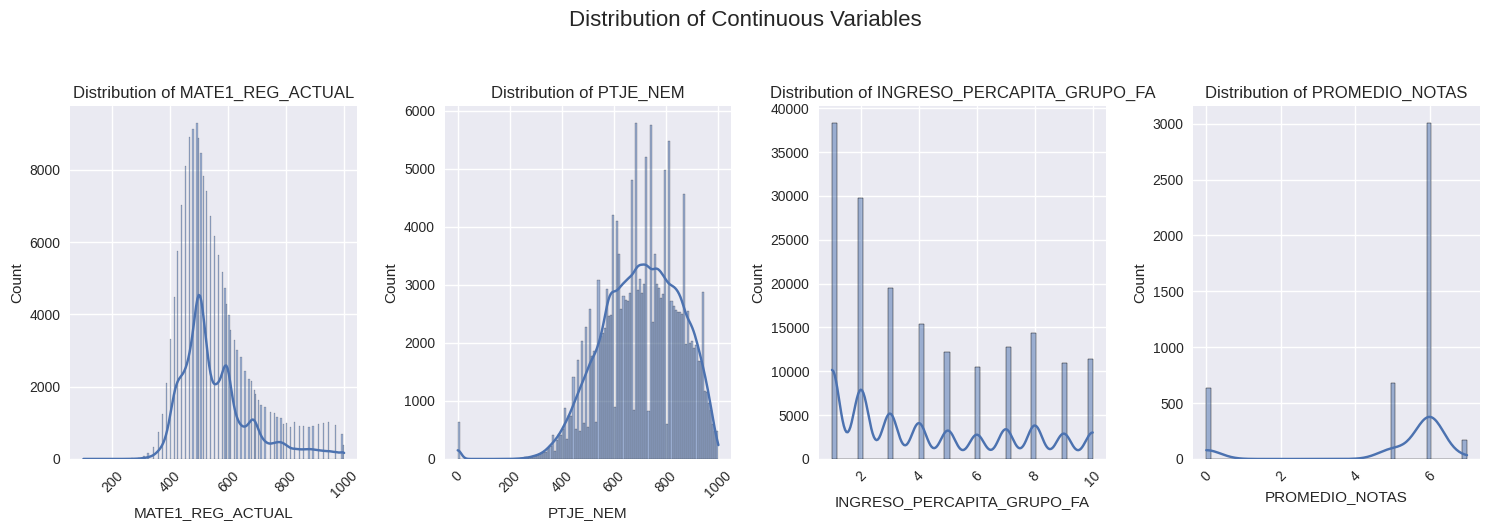

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('seaborn')

continuous_vars = [
    'MATE1_REG_ACTUAL',
    'PTJE_NEM',
    'INGRESO_PERCAPITA_GRUPO_FA','PROMEDIO_NOTAS'
]

fig, axes = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle('Distribution of Continuous Variables', fontsize=16, y=1.05)


for idx, var in enumerate(continuous_vars):
    sns.histplot(
        data=data,
        x=var,
        kde=True,
        ax=axes[idx]
    )
    axes[idx].set_title(f'Distribution of {var}')
    axes[idx].set_xlabel(var)
    axes[idx].set_ylabel('Count')

    axes[idx].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

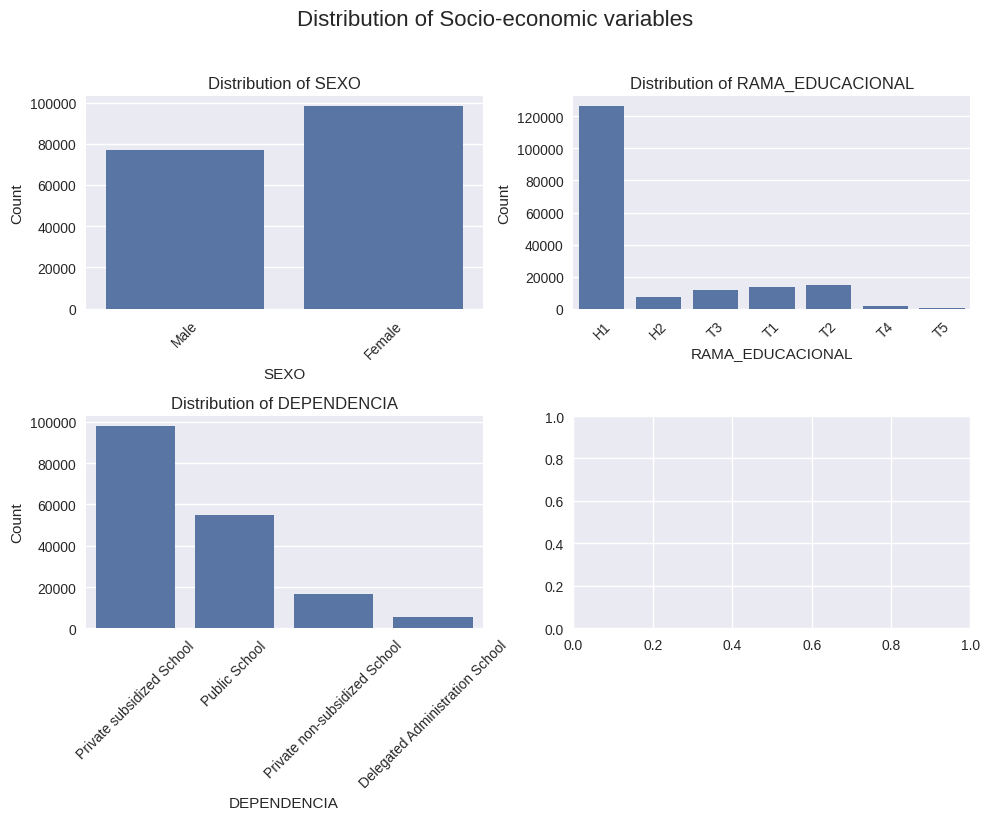

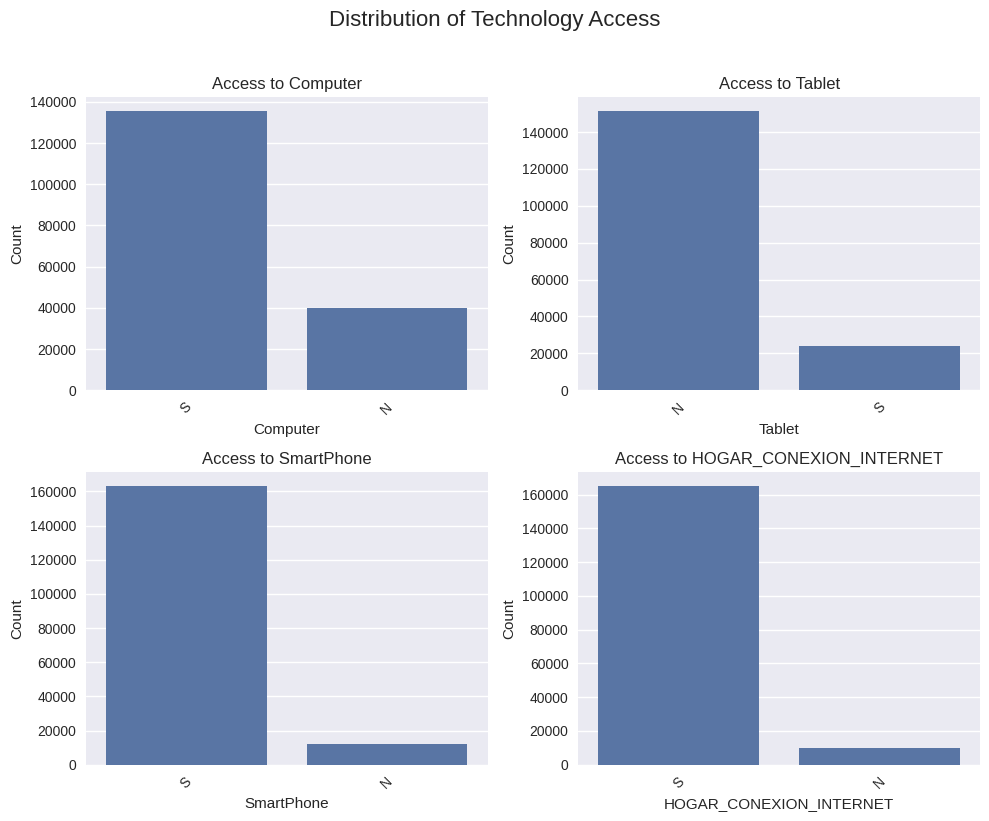

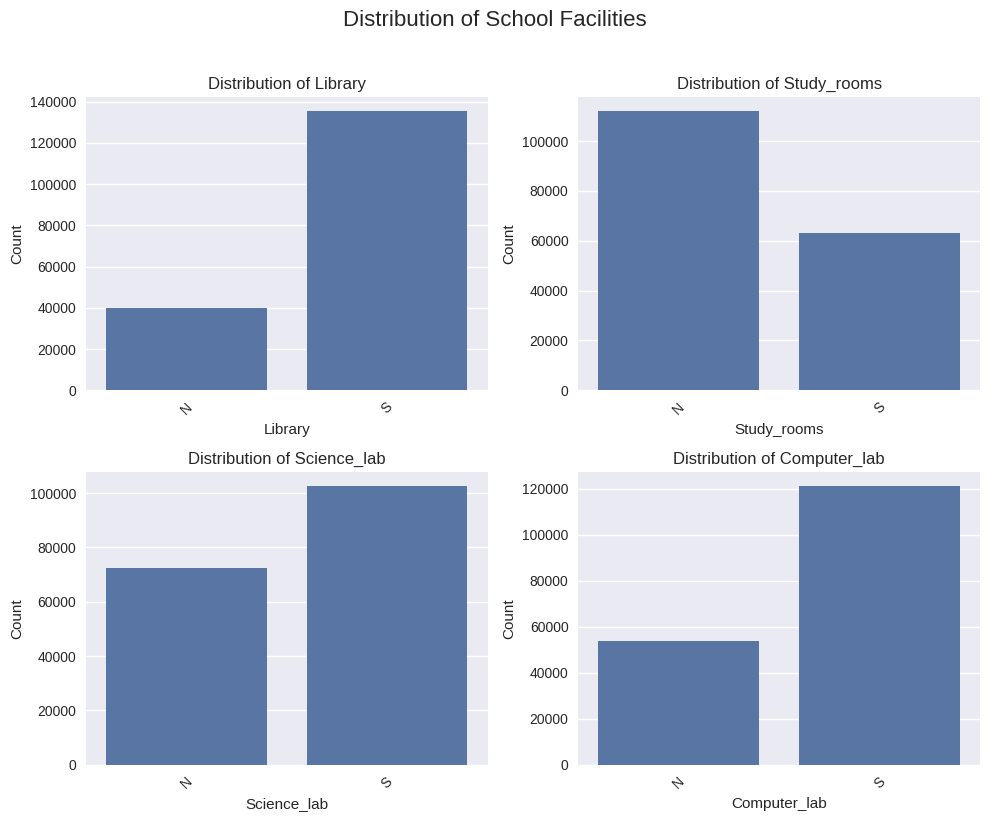

In [4]:
categorical_vars = [
    'SEXO',
    'RAMA_EDUCACIONAL',
    'DEPENDENCIA'
]

fig2, axes = plt.subplots(2, 2, figsize=(10, 8))
fig2.suptitle('Distribution of Socio-economic variables', fontsize=16, y=1.02)

for idx, var in enumerate(categorical_vars):
    row = idx // 2
    col = idx % 2

    sns.countplot(
        data=data,
        x=var,
        ax=axes[row, col]
    )
    axes[row, col].set_title(f'Distribution of {var}')
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Count')
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()

tech_vars = ['Computer', 'Tablet', 'SmartPhone', 'HOGAR_CONEXION_INTERNET']

fig3, axes = plt.subplots(2, 2, figsize=(10, 8))
fig3.suptitle('Distribution of Technology Access', fontsize=16, y=1.02)

for idx, var in enumerate(tech_vars):
    row = idx // 2
    col = idx % 2

    sns.countplot(
        data=data,
        x=var,
        ax=axes[row, col]
    )
    axes[row, col].set_title(f'Access to {var}')
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Count')
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()

facility_vars = ['Library', 'Study_rooms', 'Science_lab', 'Computer_lab']

fig4, axes = plt.subplots(2, 2, figsize=(10, 8))
fig4.suptitle('Distribution of School Facilities', fontsize=16, y=1.02)

for idx, var in enumerate(facility_vars):
    row = idx // 2
    col = idx % 2

    sns.countplot(
        data=data,
        x=var,
        ax=axes[row, col]
    )
    axes[row, col].set_title(f'Distribution of {var}')
    axes[row, col].set_xlabel(var)
    axes[row, col].set_ylabel('Count')
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout()

# Display all plots
plt.show()

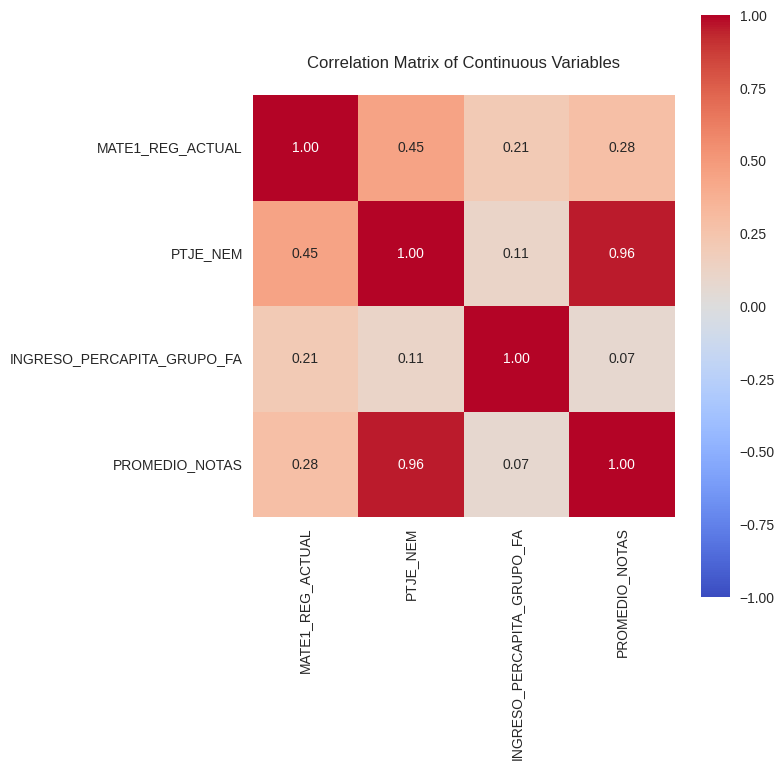

In [5]:


correlation_matrix = data[continuous_vars].corr()

plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap='coolwarm',
            vmin=-1, vmax=1,
            center=0,
            fmt='.2f',
            square=True)

plt.title('Correlation Matrix of Continuous Variables', pad=20)
plt.tight_layout()
plt.show()

# Model selection and parital dependency plots

In [6]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from alepython import ale_plot


In [7]:
# Reduce dtaset and prepare data as it has categorical and numerical variables\

numerical_vars = ['PTJE_NEM', 'INGRESO_PERCAPITA_GRUPO_FA']

binary_vars = [ 'SEXO',
               'Computer', 'Tablet', 'SmartPhone', 'HOGAR_CONEXION_INTERNET','Library', 'Study_rooms', 'Science_lab',
               'Art_room', 'Kitchen', 'Tech_lab', 'PE_Gym', 'Computer_lab',
             ]

target = 'MATE1_REG_ACTUAL'

X = data[numerical_vars].copy()

# encode DEPENDENCIA
le = LabelEncoder()
X['DEPENDENCIA'] = le.fit_transform(data['DEPENDENCIA'])
print("\nDEPENDENCIA categories:")
for i, category in enumerate(le.classes_):
    print(f"{category} = {i}")

# encode REGION
le_reg = LabelEncoder()
X['REGION'] = le_reg.fit_transform(data['REGION'])
print("\nRegion categories:")
for i, category in enumerate(le_reg.classes_):
    print(f"{category} = {i}")


# transform binary categories to binary vars
for col in binary_vars:
        if col == 'SEXO':
            X[col] = (data[col] == 'Male').astype(int)
        else:
            X[col] = (data[col] == 'S').astype(int)

y = data[target]


DEPENDENCIA categories:
Delegated Administration School = 0
Private non-subsidized School = 1
Private subsidized School = 2
Public School = 3

Region categories:
OTRAS REGIONES = 0
REGION DE LA ARAUCANIA = 1
REGION DE VALPARAISO = 2
REGION DEL BIOBIO = 3
REGION DEL MAULE = 4
REGION METROPOLITANA DE SANTIAGO = 5


In [8]:
import numpy as np
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=15, min_samples_leaf=10,
                               n_jobs=-1, random_state=42)
rf_model.fit(X_train, y_train)

# Model performance
y_pred = rf_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance:")
print(f"Mean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f}")
print(f"R-squared Score: {r2:.2f}")



Model Performance:
Mean Squared Error: 9103.55
Root Mean Squared Error: 95.41
R-squared Score: 0.43


In [9]:
importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance': rf_model.feature_importances_
})
importance_df = importance_df.sort_values('importance', ascending=False)
importance_df

,feature,importance
0,PTJE_NEM,0.545298
2,DEPENDENCIA,0.164855
4,SEXO,0.101062
1,INGRESO_PERCAPITA_GRUPO_FA,0.047083
3,REGION,0.034797
10,Study_rooms,0.020897
11,Science_lab,0.014980
15,PE_Gym,0.010297
12,Art_room,0.010118
5,Computer,0.008789


# Partial Dependance Plots

## Continuous variables

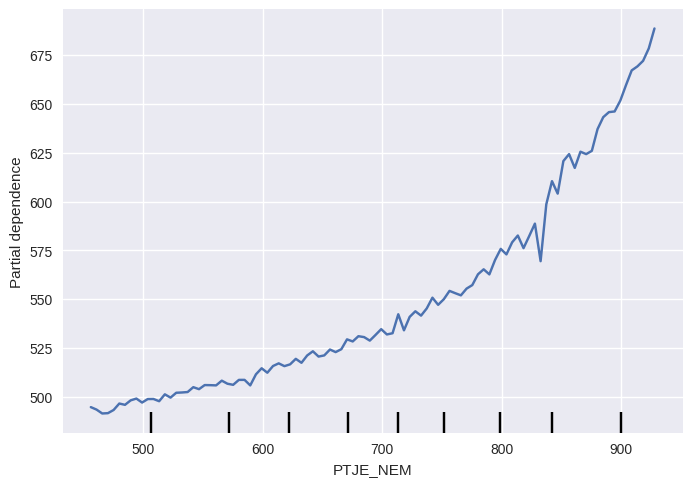

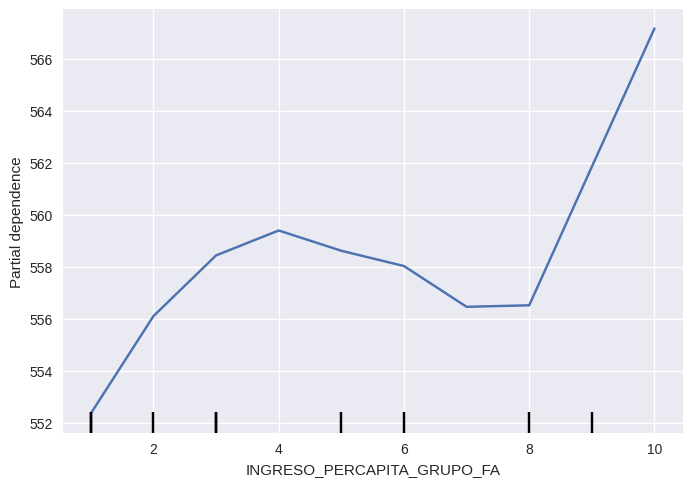

In [10]:
from sklearn.inspection import PartialDependenceDisplay

numerical_features = ['PTJE_NEM', 'INGRESO_PERCAPITA_GRUPO_FA']
for feature in X_train[numerical_features]:
  PartialDependenceDisplay.from_estimator(
        rf_model, X_train, [feature]
    )

### Interpretation


*   Highschool GPA (PTJE_NEM): the postive but non-smooth trend shows positive relationship between the highscool gpa and the math score on the unviersity entrance exam. However, the chunkyness of the line shows that teh relation is not perfectly linear where there are certain thresholds or group, example: gpa between 800 and 900 have large jumps in the math score showing that gpa is not explaing math score that well.
*   Per Capita Income:



## Dummy variables

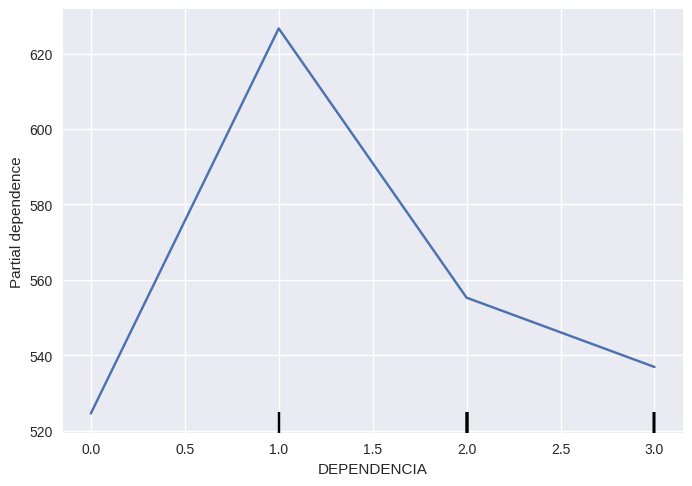

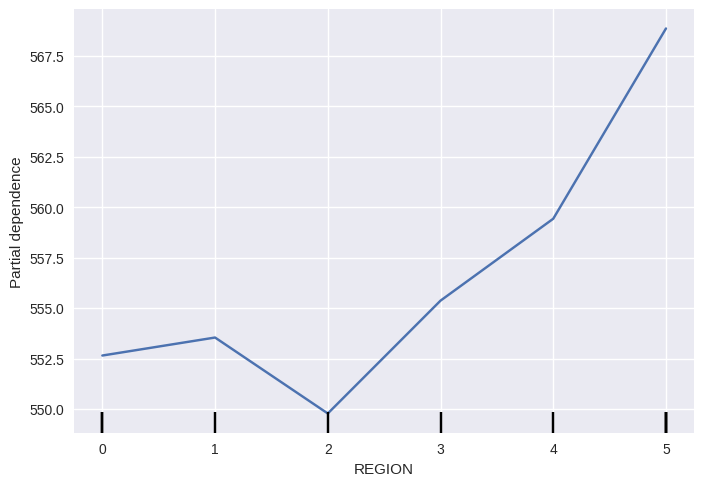

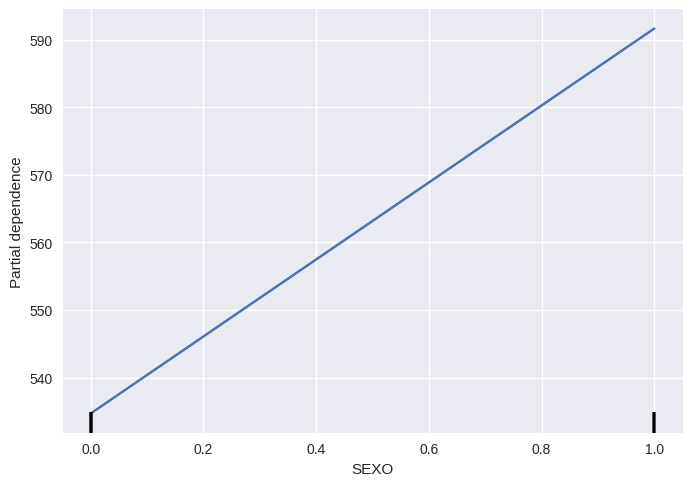

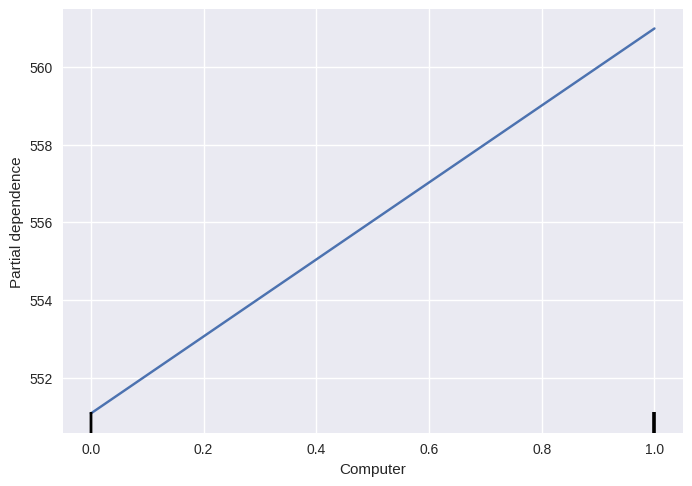

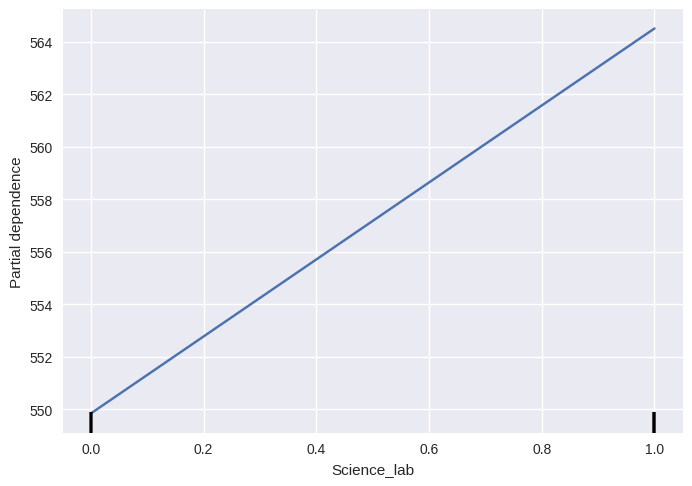

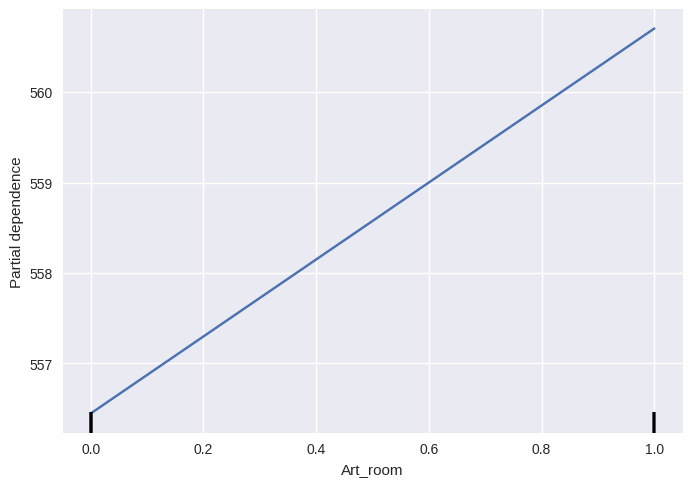

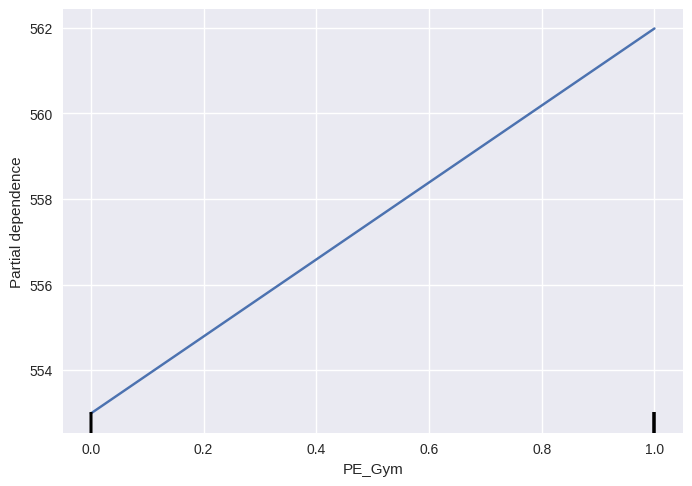

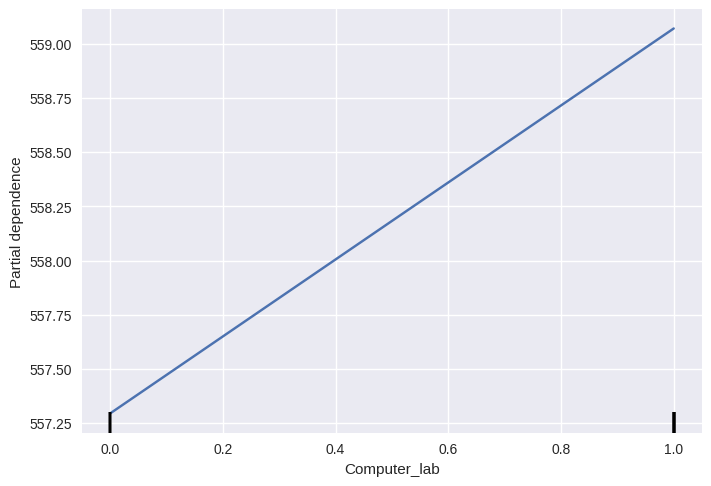

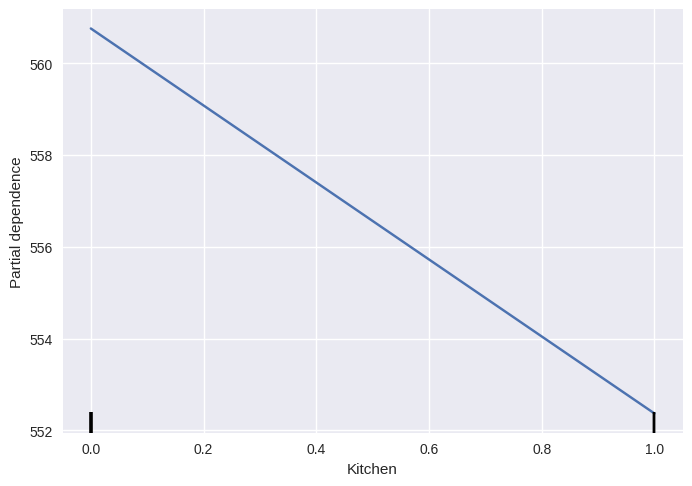

In [11]:
categorical_features = ['DEPENDENCIA', 'REGION', 'SEXO', 'Computer','Science_lab',
                       'Art_room', 'PE_Gym', 'Computer_lab', "Kitchen"]



for feature in X_train[categorical_features]:
    PartialDependenceDisplay.from_estimator(
        rf_model, X_train, [feature]
    )
    plt.show()



### Interpretation:


*   Dependencia:

Delegated Administration School = 0,
Private non-subsidized School = 1,
Private subsidized School = 2,
Public School = 3,

The large jump between categories shows that going to private schools matters most in determining math scores than attendig public schools

*   Region:

OTRAS REGIONES = 0
REGION DE LA ARAUCANIA = 1
REGION DE VALPARAISO = 2
REGION DEL BIOBIO = 3
REGION DEL MAULE = 4
REGION METROPOLITANA DE SANTIAGO = 5

The high difference between Santiago (the capital) and the lowest (Valparaiso), shows that region does influence the score.


Dummy variables
- Being male vs female has a huge influence in the score, more than 50 points in difference
- Having access to computer has a low positive effect on the score ( 8 points)
- Having science facilites at school has a larger positive effect on the score (14 points)
- Having art facilites at school has a large effect on the score (13 points)
- Having a PE GYM has large positive effect on math score (10 points)
- Having a computer lab has large positive effect on math score (12 points)

Overall, school facilites have larger effects than school region but lower than gender. However it could be possible that these could be correlated with private school as private schools have the budgets to have equipped facilites than public schools.



# Individual Conditional Expectation (ICE) Plots

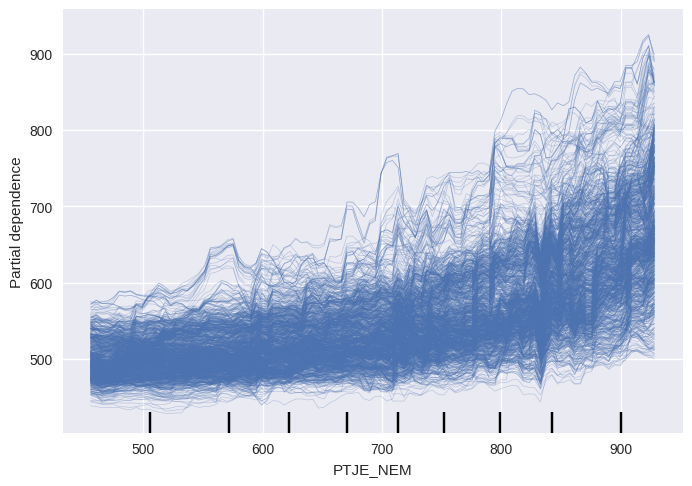

In [12]:
PartialDependenceDisplay.from_estimator(
        rf_model, X_train, ['PTJE_NEM'],  kind='individual'
  )

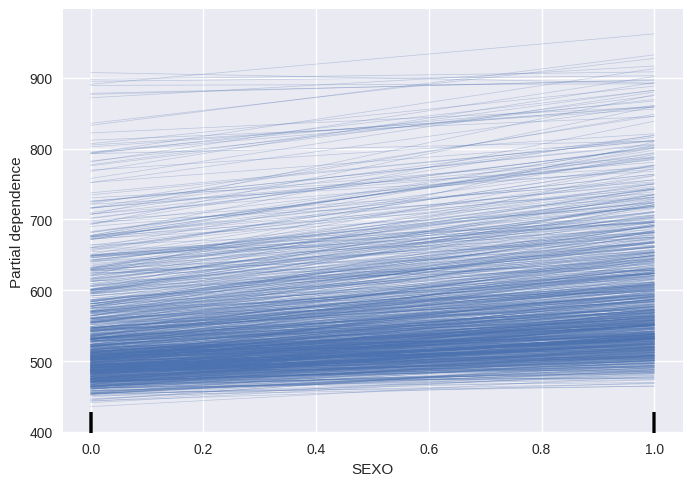

In [13]:
PartialDependenceDisplay.from_estimator(
        rf_model, X_train, ['SEXO'],  kind='individual'
  )

### Interpretation

The ICE plot shows the effect of the feature variable of each data point on the prediction, where all data points are shown in the graph. This makes each point salient, whereas the PDP showed the averaged effect.


*    High school GPA: shows a postive realationship for most of the points, however the realtionship is not completly linear

*    Gender: The ICE plot shows how gender affects differntly the math score. An upwards trend is perceived, showing that being male has a positive effect in the score, however the difference increases or becomes steeper and more clear as the score increments.



# Accumulated Local Effects Plots (ALE)


In [ ]:
ale_plot(rf_model, X_train, features=['PTJE_NEM'], bins=25, monte_carlo=True)


### Interpretation
* The ALE Plot for highschool GPA indicates a postive relationship between highschool notes and and math score, where as the GPA increases so does the math score. However, the relationship is not linear and we can see a steeper
change after a score of 780, noting that having a GPA above this has a stronger effect in predicting the score.